In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import wandb
import pickle
from tqdm import tqdm
import nlp_utils as nu
import matplotlib.pyplot as plt
import string

/home/nsl/gpu_env_pip/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("PyTorch version:", torch.__version__)

PyTorch version: 2.2.2+cu121


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: sachinsharma (iiitd-sachin). Use `wandb login --relogin` to force relogin


True

In [5]:
train_data_path = '../data/Subtask_1_train.json'
test_data_path = '../data/Subtask_1_test.json'
pickle_save_path = '../data/pickle/'
model_save_path = '../models/'

In [6]:
dataset = pd.read_json(train_data_path)
# train_df

In [7]:
conversations_df = pd.read_json(train_data_path)['conversation']
conversations_df[0]

[{'utterance_ID': 1,
  'text': 'Alright , so I am back in high school , I am standing in the middle of the cafeteria , and I realize I am totally naked .',
  'speaker': 'Chandler',
  'emotion': 'neutral'},
 {'utterance_ID': 2,
  'text': 'Oh , yeah . Had that dream .',
  'speaker': 'All',
  'emotion': 'neutral'},
 {'utterance_ID': 3,
  'text': 'Then I look down , and I realize there is a phone ... there .',
  'speaker': 'Chandler',
  'emotion': 'surprise'},
 {'utterance_ID': 4,
  'text': 'Instead of ... ?',
  'speaker': 'Joey',
  'emotion': 'surprise'},
 {'utterance_ID': 5,
  'text': 'That is right .',
  'speaker': 'Chandler',
  'emotion': 'anger'},
 {'utterance_ID': 6,
  'text': 'Never had that dream .',
  'speaker': 'Joey',
  'emotion': 'neutral'},
 {'utterance_ID': 7,
  'text': 'No .',
  'speaker': 'Phoebe',
  'emotion': 'neutral'},
 {'utterance_ID': 8,
  'text': 'All of a sudden , the phone starts to ring .',
  'speaker': 'Chandler',
  'emotion': 'neutral'}]

In [8]:
unique_labels = set()
unique_speakers = set()

for conv in conversations_df:
    for utterance in conv:
        unique_labels.add(utterance['emotion'])
        unique_speakers.add(utterance['speaker'])
unique_labels

{'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'}

In [10]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(list(unique_labels))

label_dict_save_path = pickle_save_path + "label_dict.pkl"
labels_dict = {x:label_encoder.transform([x])[0] for x in label_encoder.classes_}
pickle.dump(labels_dict, open(label_dict_save_path, "wb"))

In [11]:
train_conv_df, dev_conv_df = train_test_split(conversations_df, test_size=0.2, random_state=42)

In [12]:
train_conversations = []
dev_conversations = []
train_conv_emotions = []
dev_conv_emotions = []

train_utterances = []
train_emotions = []
train_speakers = []

dev_utterances = []
dev_emotions = []
dev_speakers = []

for conv in train_conv_df:
    dialog = []
    dialog_emotions = []
    for sentence in conv:
        speaker = sentence['speaker']
        utterance = f'{speaker}: ' + nu.preprocess_text(sentence['text'])
        emotion = sentence['emotion']
        train_utterances.append(utterance)
        dialog.append(utterance)
        train_speakers.append(speaker)
        train_emotions.append(sentence['emotion'])
        dialog_emotions.append(sentence['emotion'])
    train_conversations.append(dialog)
    train_conv_emotions.append(dialog_emotions)

for conv in dev_conv_df:
    dialog = []
    dialog_emotions = []
    for sentence in conv:
        speaker = sentence['speaker']
        utterance = f'{speaker}: ' + nu.preprocess_text(sentence['text'])
        emotion = sentence['emotion']
        dev_utterances.append(utterance)
        dialog.append(utterance)
        dev_speakers.append(speaker)
        dev_emotions.append(sentence['emotion'])
        dialog_emotions.append(sentence['emotion'])
    dev_conversations.append(dialog)
    dev_conv_emotions.append(dialog_emotions)

train_emotions = label_encoder.transform(train_emotions)
dev_emotions = label_encoder.transform(dev_emotions)

train_conv_emotions = np.array([label_encoder.transform(x) for x in train_conv_emotions], dtype='object')
dev_conv_emotions = np.array([label_encoder.transform(x) for x in dev_conv_emotions], dtype='object')

In [13]:
def encode_conversations(conv, tokenizer, max_length=128):
    conv_input_ids = []
    conv_attention_masks = []

    for utterances in tqdm(conv, total=len(conv), desc="Encoding conversations"):
        input_ids = []
        attention_masks = []
        for sentence in utterances:
            encoded = tokenizer.encode_plus(sentence,
                                    add_special_tokens=True,
                                    max_length=max_length,
                                    padding='max_length',
                                    truncation=True,
                                    return_attention_mask=True,
                                    return_tensors='pt')
            input_ids.append(encoded['input_ids'])
            attention_masks.append(encoded['attention_mask'])

        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        conv_input_ids.append(input_ids)
        conv_attention_masks.append(attention_masks)

    return {'input_ids': np.array(conv_input_ids, dtype='object'), 'attention_mask': np.array(conv_attention_masks, dtype='object')}

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [15]:
train_encodings = encode_conversations(train_conversations, tokenizer)
dev_encodings = encode_conversations(dev_conversations, tokenizer)

Encoding conversations: 100%|██████████| 275/275 [00:01<00:00, 258.41it/s]


In [16]:
X_train_input_ids = train_encodings['input_ids']
X_train_attention_masks = train_encodings['attention_mask']

X_dev_input_ids = dev_encodings['input_ids']
X_dev_attention_masks = dev_encodings['attention_mask']

X_train_input_ids.shape
# X_dev_input_ids.shape

(1099,)

In [17]:
torch.save(X_train_input_ids, pickle_save_path + 'X_train_input_ids.pt')
torch.save(X_train_attention_masks, pickle_save_path + 'X_train_attention_masks.pt')
torch.save(train_conv_emotions, pickle_save_path + 'train_labels_2d.pt')

torch.save(X_dev_input_ids, pickle_save_path + 'X_dev_input_ids.pt')
torch.save(X_dev_attention_masks, pickle_save_path + 'X_dev_attention_masks.pt')
torch.save(dev_conv_emotions, pickle_save_path + 'dev_labels_2d.pt')

In [18]:
X_train_input_ids = torch.load(pickle_save_path + 'X_train_input_ids.pt')
X_train_attention_masks = torch.load(pickle_save_path + 'X_train_attention_masks.pt')
train_labels = torch.load(pickle_save_path + 'train_labels_2d.pt')

X_dev_input_ids = torch.load(pickle_save_path + 'X_dev_input_ids.pt')
X_dev_attention_masks = torch.load(pickle_save_path + 'X_dev_attention_masks.pt')
dev_labels = torch.load(pickle_save_path + 'dev_labels_2d.pt')

In [19]:
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

In [21]:
def train_step(model, input_ids, attention_mask, labels):
    model.train()
    optimizer.zero_grad()
    predictions = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = predictions[0]
    loss.backward()
    optimizer.step()
    return loss.item()

In [22]:
wandb.init(
    project="NLP_Project",
    group='ERC',
    name='Bert-erc-no_context-run1',

    config={
        "architecture": "bert",
        'context': 'not_concatenated',
        'input shape': 'conversation',
        "epochs": 3,
        "learning_rate": 1e-5
    }
)
config = wandb.config

num_epochs = config.epochs
train_losses = []
dev_losses = []

for epoch in range(num_epochs):
    epoch_train_loss = 0

    for utterance, mask, labels in tqdm(zip(X_train_input_ids, X_train_attention_masks, train_labels), total=len(train_conversations), desc=f"Epoch {epoch+1}"):
        input_ids = utterance.to(device)
        mask = mask.to(device)
        labels = torch.tensor(labels, dtype=torch.long).to(device)
        loss = train_step(model, input_ids, mask, labels)
        epoch_train_loss += loss
    epoch_train_loss /= len(train_conversations)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    total_dev_loss = 0
    with torch.no_grad():
        for utterance, mask, labels in zip(X_dev_input_ids, X_dev_attention_masks, dev_labels):
            input_ids = utterance.to(device)
            mask = mask.to(device)
            labels = torch.tensor(labels, dtype=torch.long).to(device)
            predictions = model(input_ids, attention_mask=mask, labels=labels)
            dev_loss = predictions[0]
            total_dev_loss += dev_loss.item()
    avg_dev_loss = total_dev_loss / len(dev_conversations)
    dev_losses.append(avg_dev_loss)

    wandb.log({'train_loss': epoch_train_loss, 'val_loss': avg_dev_loss})
    print(
        f'Training Loss: {epoch_train_loss}, Validation Loss: {avg_dev_loss}')

wandb.finish()

Epoch 1: 100%|██████████| 1099/1099 [01:30<00:00, 12.13it/s]


Training Loss: 1.4006328778824446, Validation Loss: 1.27698785868558


Epoch 2: 100%|██████████| 1099/1099 [01:30<00:00, 12.09it/s]


Training Loss: 1.1389070726097226, Validation Loss: 1.281329187317328


Epoch 3: 100%|██████████| 1099/1099 [01:28<00:00, 12.49it/s]


Training Loss: 0.9392065886980951, Validation Loss: 1.3668078440563245


train_loss,█▄▁
val_loss,▁▁█
train_loss,0.93921
val_loss,1.36681


In [23]:
model.save_pretrained(model_save_path + 'erc-bert-m2')
# tokenizer.save_pretrained(model_save_path)

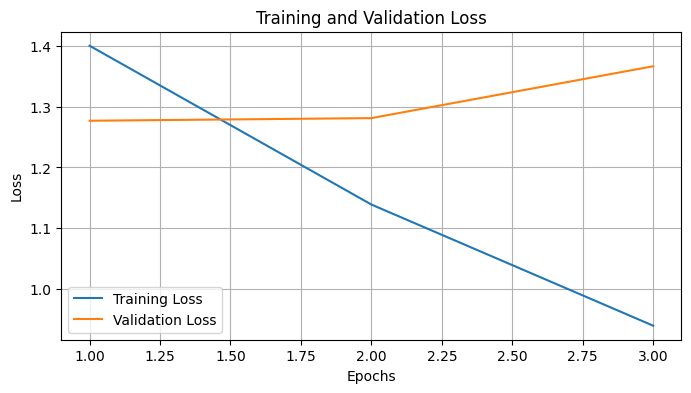

In [24]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), dev_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for utterance, mask, labels in zip(X_dev_input_ids, X_dev_attention_masks, dev_labels):
        input_ids = utterance.to(device)
        mask = mask.to(device)
        labels = torch.tensor(labels, dtype=torch.long).to(device)
        outputs = model(input_ids, attention_mask=mask, labels=labels)
        predictions.append(np.argmax(outputs.logits.to('cpu').numpy(), axis=1))
        true_labels.extend(labels.cpu().numpy())

In [26]:
predictions = np.concatenate(predictions, axis=0)

In [27]:
np.array(true_labels)

array([3, 4, 3, ..., 3, 3, 1])

In [28]:
predictions

array([3, 4, 4, ..., 4, 4, 4])

In [29]:
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted')
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')

In [30]:
print(classification_report(true_labels, predictions, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

       anger       0.39      0.34      0.36       294
     disgust       0.33      0.07      0.12        96
        fear       0.07      0.02      0.03        90
         joy       0.52      0.49      0.50       485
     neutral       0.63      0.70      0.66      1132
     sadness       0.28      0.42      0.34       198
    surprise       0.58      0.55      0.56       359

    accuracy                           0.53      2654
   macro avg       0.40      0.37      0.37      2654
weighted avg       0.52      0.53      0.52      2654



In [31]:
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.53353428786737
Precision: 0.5200249251666161
Recall: 0.53353428786737
F1 Score: 0.5209382264091214
